# Rainfall retreival

In [1]:
import xarray as xr
import datatree
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.transforms as mtransforms
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap

2024-03-22 07:52:52.126072: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 07:52:52.735414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Local Cluster

Let's spin up our `Dask` local cluster

In [2]:
cluster = LocalCluster()  
# display(cluster)

## Data

In [3]:
path_data = '../data/camp2ex_dtree.zarr'
dt_camp2ex = datatree.open_datatree(path_data, engine='zarr', consolidated=True)
path_kmeans = '../data/df_cluster.parquet'
df = pd.read_parquet(path_kmeans)

## Deep Neural Network

In [4]:
model = tf.keras.models.load_model(f"../data/dnn_zku_Dfr_temp_ka_16x6.keras")

2024-03-22 07:52:55.166283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 07:52:55.197975: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'log10_nw', 'dm', 'mu_unc']]
Y = df[['dm_class',  'r', 'kmeans', 'time', 'r_dm_gm_mu_3', 'r_gpm_operational', 
        'r_true_nw_mu_dm', 'dm_rt_dfr_nd_mu_3', 'log10nw_dm_gm_mu_3', 'mu_3']]

In [6]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'mu_unc']])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=40, stratify=df.kmeans)
X_train.shape

(6321, 7)

In [7]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [8]:
def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

# function that computes the Normalized-Gama size distribution
def norm_gamma(d, nw, mu, dm):
    """
    Functions that computes the normalized-gamma size distritubion (Testud et al., 2002)
    Param d: diameter in mm
    Param nw: Normalized intercep parameter
    Param mu: Shape parameter
    Param dm: Mass-weighted mean diameter
    """
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

In [9]:
# defining the Colormap for each cluster identified
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))

In [10]:
n_c = 6

## NGSD parameter retrieval comparison

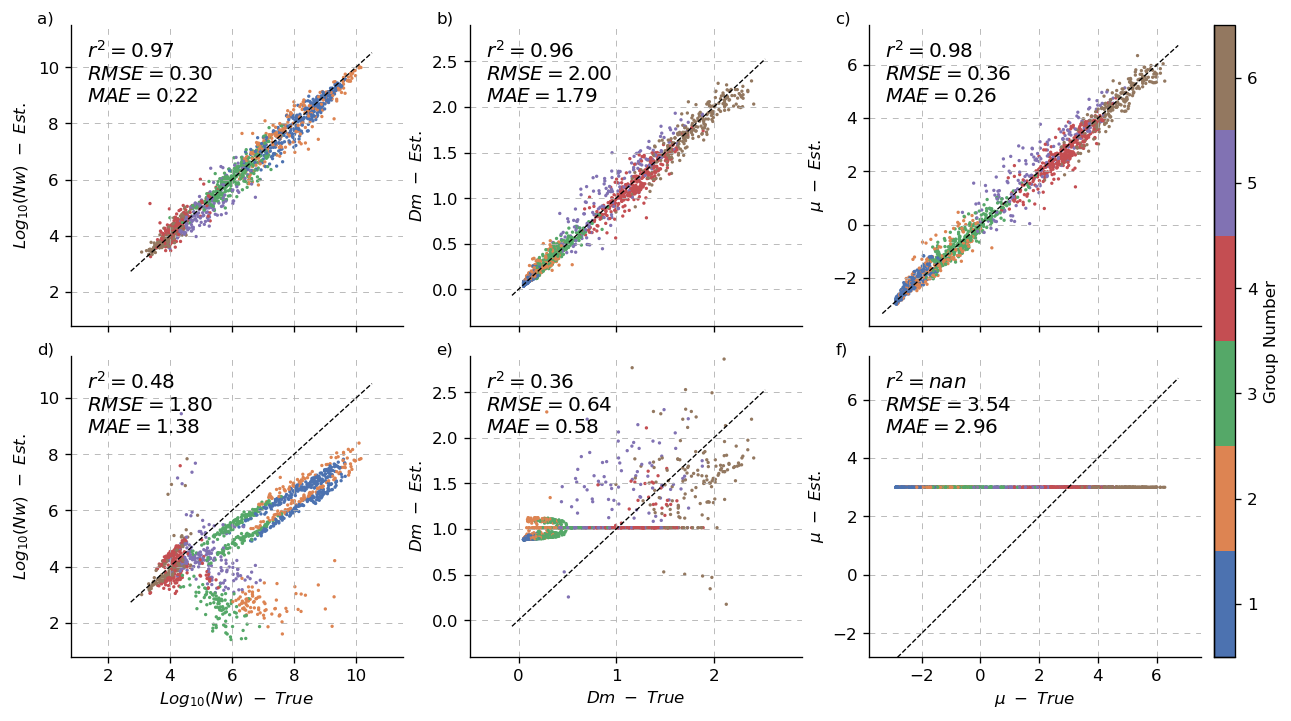

In [11]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)'], ['d)', 'e)', 'f)']], figsize=(12,6), dpi=120)

ax = axs['a)']
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax.set_xlim(0.8, 11.5)
ax.set_ylim(0.8, 11.5)
ax.set_xticklabels("")


ax1 = axs['b)']
ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test.kmeans, cmap=my_cmap6)
# ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
# ax1.set_xlim(-0.5, 3)
# ax1.set_ylim(-0.5, 3)
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.5, 2.9)
ax1.set_ylim(-0.4, 2.9)
ax1.set_xticklabels("")


ax2 = axs['c)']
sc2 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test.kmeans, cmap=my_cmap6)
# ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.set_xlim(-3.8, 7.5)
ax2.set_ylim(-3.8, 7.5)
ax2.set_xticklabels("")

ax3 = axs['d)']
ax3.scatter(y_test_unscaled[:, 0], y_test.log10nw_dm_gm_mu_3 / 10, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax3.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax3.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax3.get_xlim())
ax3.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], y_test.log10nw_dm_gm_mu_3 / 10)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=12,
        verticalalignment='top')
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax3.set_xlim(0.8, 11.5)
ax3.set_ylim(0.8, 11.5)

ax4 = axs['e)']
ax4.scatter(y_test_unscaled[:, 1], y_test.dm_rt_dfr_nd_mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax4.set_xlabel(r"$Dm \ - \ True $")
ax4.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax4.get_xlim())
ax4.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], y_test.dm_rt_dfr_nd_mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=12,
        verticalalignment='top')
ax4.set_xlim(-0.5, 2.9)
ax4.set_ylim(-0.4, 2.9)
ax4.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax5 = axs['f)']
ax5.scatter(y_test_unscaled[:, 2], y_test.mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax5.set_xlabel(r"$\mu  \ - \ True $")
ax5.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], y_test.mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax5.text(0.05, 0.95, textstr, transform=ax5.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax5.get_xlim())
ax5.plot(x, x, c='k', ls='--', lw=0.8)
ax5.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax5.set_xlim(-3.8, 7.5)
ax5.set_ylim(-2.8, 7.5)

plt.tight_layout()
plt.subplots_adjust(wspace=None, hspace=0.1)

cbar = fig.colorbar(sc2, ax=[ax, ax1, ax2, ax3, ax4, ax5], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
sns.despine()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-20/72, 8/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    

In [12]:
df_test = pd.DataFrame(data=y_test_unscaled, columns=['log10_nw', 'dm', 'mu'])
df_est = pd.DataFrame(data=yhat, columns=['log10_nw_hat', 'dm_hat', 'mu_hat'])
df_dnn = pd.concat([df_test, df_est, y_test['kmeans'].reset_index()], axis=1)
df_dnn['dm_error'] = 100 * (df_dnn['dm'] - df_dnn['dm_hat']) /  df_dnn['dm']
df_dnn['dm_error_abs'] = df_dnn['dm'] - df_dnn['dm_hat']
df_dnn['log10_nw_error'] = 100 * (df_dnn['log10_nw'] - df_dnn['log10_nw_hat']) /  df_dnn['log10_nw']
df_dnn['log10_nw_error_abs'] = df_dnn['log10_nw'] - df_dnn['log10_nw_hat']
df_dnn['mu_error'] = 100 * (df_dnn['mu'] - df_dnn['mu_hat']) /  df_dnn['mu']
df_dnn['mu_error_abs']  = df_dnn['mu'] - df_dnn['mu_hat']

In [13]:
df_gpm = pd.concat([df_test, y_test.reset_index()], axis=1)

df_gpm['dm_error'] = 100 * (df_gpm['dm'] - df_gpm['dm_rt_dfr_nd_mu_3']) /  df_gpm['dm']
df_gpm['dm_error_abs'] = df_gpm['dm'] - df_gpm['dm_rt_dfr_nd_mu_3']
df_gpm['log10_nw_error'] = 100 * (df_gpm['log10_nw'] - df_gpm['log10nw_dm_gm_mu_3']) /  df_gpm['log10_nw']
df_gpm['log10_nw_error_abs'] = (df_gpm['log10_nw'] - df_gpm['log10nw_dm_gm_mu_3'])
df_gpm['mu_error'] = 100 * (df_gpm['mu'] - df_gpm['mu_3']) /  df_gpm['mu']
df_gpm['mu_error_abs']  = (df_gpm['mu'] - df_gpm['mu_3'])
df_gpm['dm_q'], bins = pd.cut(df_gpm['dm'], 20, retbins=True)
df_gpm['dm_q'] = df_gpm['dm_q'].apply(lambda x: x.mid)
df_gpm['nw_q'], bins = pd.cut(df_gpm['log10_nw'], 20, retbins=True)
df_gpm['nw_q'] = df_gpm['nw_q'].apply(lambda x: x.mid)
df_gpm['mu_q'], bins = pd.cut(df_gpm['mu'], 20, retbins=True)
df_gpm['mu_q'] = df_gpm['mu_q'].apply(lambda x: x.mid)

In [14]:
df_dnn['dm_q'], bins = pd.cut(df_dnn['dm'], 20, retbins=True)
df_dnn['dm_q'] = df_dnn['dm_q'].apply(lambda x: x.mid)
df_dnn['nw_q'], bins = pd.cut(df_dnn['log10_nw'], 20, retbins=True)
df_dnn['nw_q'] = df_dnn['nw_q'].apply(lambda x: x.mid)
df_dnn['mu_q'], bins = pd.cut(df_dnn['mu'], 20, retbins=True)
df_dnn['mu_q'] = df_dnn['mu_q'].apply(lambda x: x.mid)

In [15]:
df_dnn['source'] = "DNN"
df_gpm['source']  = "GPM-Analytical"

In [16]:
cols = ['dm_error', 'dm_error_abs', 'log10_nw_error', 'log10_nw_error_abs', 'mu_error', 'mu_error_abs', 'kmeans', 'source']
df_plot= pd.concat([df_dnn[cols], df_gpm[cols]], axis=0).reset_index()

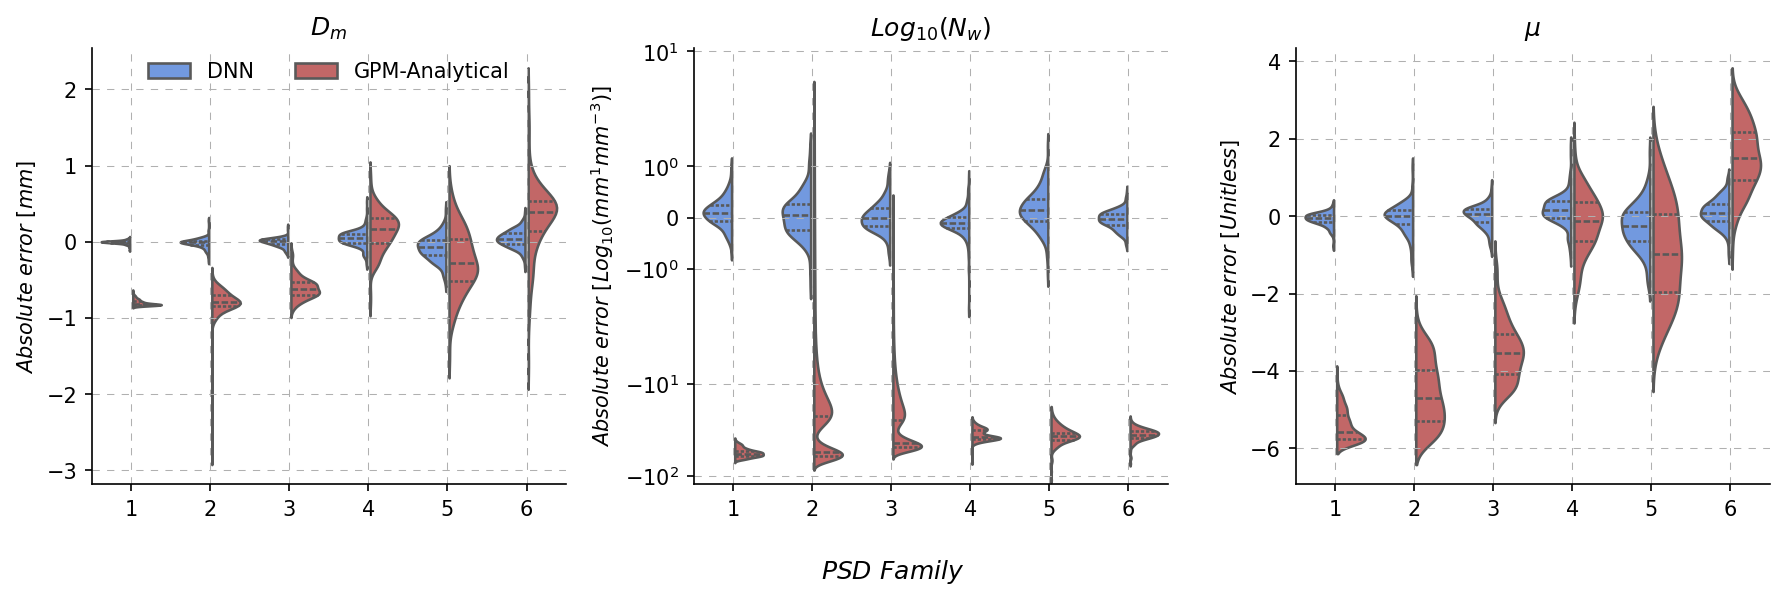

In [18]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,4), dpi=150, sharex=True)
ax = axs['a)']
g = sns.violinplot(data=df_plot, x='kmeans', y='dm_error_abs', hue='source', 
                   palette=['cornflowerblue', 'indianred'], saturation=0.8,
                   ax=ax, gap=.1, inner="quart", scale='width', legend=True, 
                   split=True)


ax.set_ylabel(r"$Absolute \ error \ [mm]$")
ax.set_xlabel('')
ax.set_title(r"$D_m$")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 0.88), ncol=2, title=None, frameon=False)


ax1 = axs['b)']
sns.violinplot(data=df_plot, x='kmeans', y='log10_nw_error_abs', hue='source', palette=['cornflowerblue', 'indianred'], saturation=0.8,
                ax=ax1, gap=.1, inner="quart", scale='width', legend=False, split=True)
# ax1.set_yscale('symlog')
ax1.set_ylabel(r"$Absolute \ error \ [Log_{10}(mm^{1}mm^{-3})]$")
ax1.set_title(r"$Log_{10}(N_w)$")
ax1.set_xlabel('')

ax2 = axs['c)']
sns.violinplot(data=df_plot, x='kmeans', y='mu_error_abs', hue='source', palette=['cornflowerblue', 'indianred'], saturation=0.8,
                ax=ax2, gap=.1, inner="quart", scale='width', legend=False, split=True)
ax1.set_yscale('symlog')
ax2.set_ylabel(r"$Absolute \ error \ [Unitless]$")
ax2.set_title(r"$\mu$")
ax2.set_xlabel('')

ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
fig.supxlabel(r"$PSD \ Family$")

sns.despine()
fig.tight_layout()

## Rainrall rate estimation

In [19]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test.time.values),
        diameter=(['diameter'], dt_camp2ex['Lear'].ds.diameter.values)
    ),
)

d_d = dt_camp2ex['Lear'].ds.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

In [20]:
def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

In [21]:
ds_sub['nn_gamma_pds'] = norm_gamma(dt_camp2ex['Lear'].ds.diameter/1000, nw=ds_sub.nw, 
                                    mu=ds_sub.mu_unc, dm=ds_sub.dm)
nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, 
                         d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

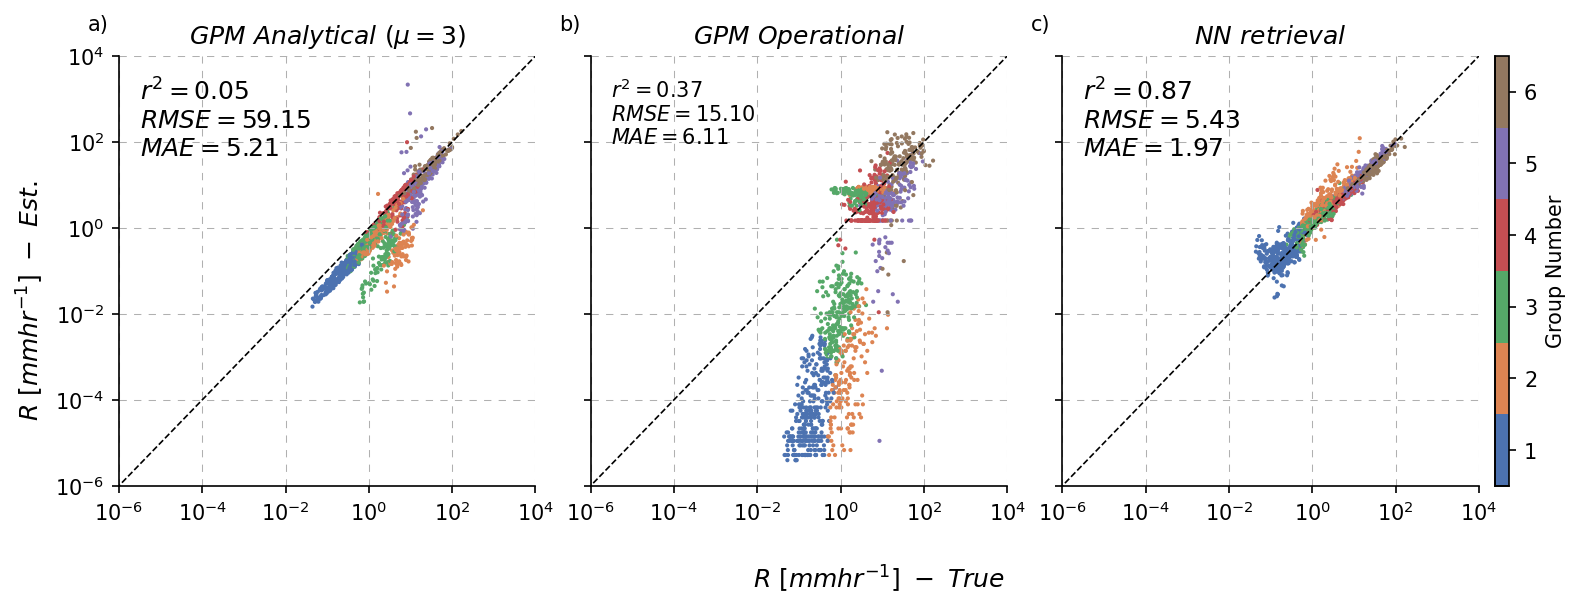

In [22]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,4), dpi=150, sharey=True)

ax = axs['a)']
sc1 = ax.scatter(y_test.r, y_test.r_dm_gm_mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
_min, _max = ax.get_xlim()
x = np.linspace(_min, _max + 1e4) 
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax.set_ylim(1e-6, 10000)
rmse, mae, corr1 = metrics_pd(y_test.r, y_test.r_dm_gm_mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-5, 180)
ax.set_title(r"$GPM \ Analytical \ (\mu=3)$")

ax1 = axs['c)']
sc1 = ax1.scatter(y_test.r, nn_rain.values, s=1, c=y_test.kmeans, cmap=my_cmap6)
_min, _max = ax1.get_xlim()
x = np.linspace(_min, _max + 1e4) 
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test.r, nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
ax1.set_xscale('log')
ax1.set_yscale('log')


ax2 = axs['b)']
sc1 = ax2.scatter(y_test.r, y_test.r_gpm_operational, s=1, c=y_test.kmeans, cmap=my_cmap6)
_min, _max = ax2.get_xlim()
x = np.linspace(_min, _max + 1e4) 
ax2.plot(x, x, c='k', ls='--', lw=0.8)

rmse, mae, corr1 = metrics_pd(y_test.r, y_test.r_gpm_operational)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, 
        verticalalignment='top')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title(r"$GPM \ Operational$")

fig.supxlabel(r"$R \ [mmhr^{-1}]\ - \ True $", fontsize=12)
fig.supylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $", fontsize=12)

ax.set_ylim(1e-6, 1e4)
ax.set_xlim(1e-6, 1e4)
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax1.set_ylim(1e-6, 1e4)
ax1.set_xlim(1e-6, 1e4)
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax2.set_ylim(1e-6, 1e4)
ax2.set_xlim(1e-6, 1e4)
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

plt.tight_layout()

cbar = fig.colorbar(sc1, ax=[ax,ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
sns.despine()
ax1.set_title(r"$NN \ retrieval$")

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-15/72, 20/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')